In [ ]:
# default_exp utils.missing

In [ ]:
#export
from capetools.imports import *
from capetools.utils.pandas_hacks import *
from sklearn.base import TransformerMixin

# Detect Missing values
> A set of tools to detect and repair missing values on timeseries data

Let's import some data

In [ ]:
DATAPATH = Path.cwd().parent/'data'
DATAPATH.ls()

(#2) [Path('/home/tc256760/Documents/capetools/data/pvgis_tmy_chambery.csv'),Path('/home/tc256760/Documents/capetools/data/sample_data.hdf')]

In [ ]:
df = pd.read_hdf(DATAPATH/'sample_data.hdf')

We can add some random noise (add random NaN).

In [ ]:
df_noisy = df.copy()
df_noisy[np.random.choice(a=[False, True], size=df.shape, p=[0.95, 1-0.95])] = np.nan

It is useful to know when the sun is up:

In [ ]:
def is_day(df: DataFrame, ghi_col='ghi')->DataFrame:
    "Day test, needs ghi col present" 
    assert ghi_col in df.columns, f'{ghi_col} is not present'
    return df[df.loc[All, ghi_col]>0]

In [ ]:
is_day(df_noisy).head()

,ghi,dni,dhi,temp_air,wind_speed,wind_dir,pressure,humidity,zenith,elevation,azimuth
Date UTC,,,,,,,,,,,
2019-01-01 07:00:00,3.61,0.0,3.82,3.95,NaN,225.0,NaN,85.8,93.381,-3.381,119.987
2019-01-01 08:00:00,19.81,0.0,19.09,3.96,2.30,214.8,1005.00,84.0,84.837,5.163,130.830
2019-01-01 09:00:00,28.79,0.0,28.28,4.39,2.44,199.4,1005.11,82.8,77.656,12.344,142.757
2019-01-01 10:00:00,36.12,0.0,37.56,4.56,1.48,179.7,1004.86,81.8,72.302,17.698,155.930
2019-01-01 11:00:00,39.01,0.0,38.49,4.97,2.61,200.5,1004.43,81.2,69.239,20.761,NaN


In [ ]:
from nbdev.showdoc import show_doc

We define a plotting method to apply a function that mask values over the `DataFrame`.
- The function `f` needs to ingest the `DataFrame` and output True or False, depending on the condition.
- You can also pass a `ghi` column to ignore timesteps where there is no light (night).

In [ ]:
#export
def plot_missing(df: DataFrame, f:Callable[[DataFrame], DataFrame]=pd.isna, ghi_col:Optional[str]=None):
    "Plot data that satisfies the f function, optional ghi_col to exclude night"
    if ghi_col is not None: 
        df = is_day(df, ghi_col)
    cols = df.columns
    n = len(cols)
    _, ax = plt.subplots(figsize=(15,n*0.3))
    outliers = f(df)
    ax.matshow(outliers.T, interpolation=None, aspect='auto')
    xticks = np.arange(0, len(outliers), int(len(outliers)/7))
    ax.set_xticks(xticks)
    ax.set_xticklabels([outliers.index[i].strftime('%d-%m-%Y') for i in xticks])
    ax.set_yticks(range(n))
    ytickslabels = [str(name)+f' ({100*outliers[name].sum()/len(outliers[name]):.3f}%)' for name in cols.values]
    ax.set_yticklabels(ytickslabels)
    return

We can see where there are the NaN's

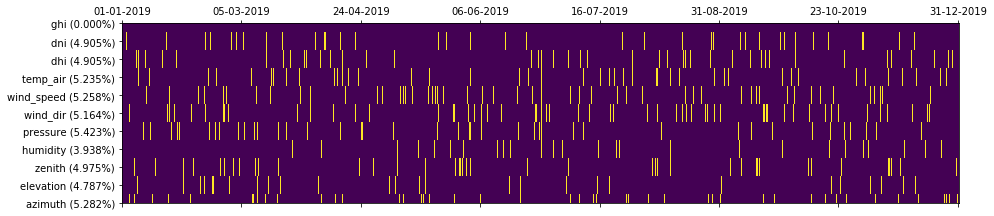

In [ ]:
plot_missing(df_noisy, ghi_col='ghi')

## Outlier functions

Outlier functions are just any function that takes as input a `DataFrame` and outputs a `DataFrame` with bool values.

In [ ]:
f = lambda df: df.isna()

In [ ]:
f(df_noisy)

,ghi,dni,dhi,temp_air,wind_speed,wind_dir,pressure,humidity,zenith,elevation,azimuth
Date UTC,,,,,,,,,,,
2019-01-01 00:00:00,False,False,False,False,False,False,False,False,False,True,False
2019-01-01 01:00:00,False,False,False,False,False,False,False,False,False,False,False
2019-01-01 02:00:00,False,False,False,False,False,False,False,False,True,False,False
2019-01-01 03:00:00,False,False,False,False,False,False,False,False,False,False,False
2019-01-01 04:00:00,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,False,False,False,False,False,False,False,False,False,False,False
2019-12-31 20:00:00,False,False,False,True,False,False,False,False,False,False,True
2019-12-31 21:00:00,False,False,False,False,False,True,False,False,False,False,True


We can define more interesting functions than `pd.isna`

In [ ]:
#export
def std_outliers(mean=0, std=1, std_coef=3):
    "Std outlier test func"
    def _inner(df): return (np.abs(df-mean)>std_coef*std)
    return _inner

def diff_outliers(std=1, std_coef=2):
    "Std test on 1st derivative"
    def _inner(df): return (df.diff().abs()>std_coef*std)
    return _inner

In [ ]:
f_std = std_outliers(df.mean(), df.std())

You can directly apply the function to the `DataFrame`, it returs True where there is an outlier.

In [ ]:
f_std(df_noisy)

,ghi,dni,dhi,temp_air,wind_speed,wind_dir,pressure,humidity,zenith,elevation,azimuth
Date UTC,,,,,,,,,,,
2019-01-01 00:00:00,False,False,False,False,False,False,False,False,False,False,False
2019-01-01 01:00:00,False,False,False,False,False,False,False,False,False,False,False
2019-01-01 02:00:00,False,False,False,False,False,False,False,False,False,False,False
2019-01-01 03:00:00,False,False,False,False,False,False,False,False,False,False,False
2019-01-01 04:00:00,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,False,False,False,False,False,False,False,False,False,False,False
2019-12-31 20:00:00,False,False,False,False,False,False,False,False,False,False,False
2019-12-31 21:00:00,False,False,False,False,False,False,False,False,False,False,False


It shows the values that are more than 3 stds away from the mean (95% normal distribution cutoff)

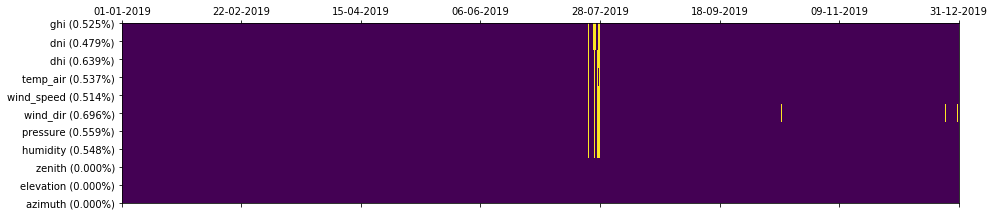

In [ ]:
plot_missing(df_noisy, f=f_std)

We can further explore this, A lot of values are bad and stuck at -9999, this has to be corrected or dropped.

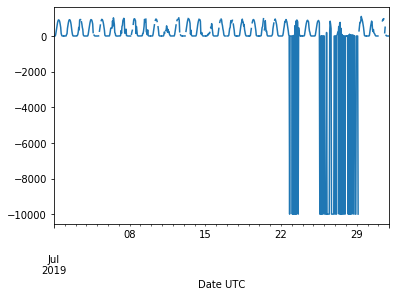

In [ ]:
df_noisy.loc['7 2019', 'ghi'].plot();

We can also compose various criteria: 

In [ ]:
#export
def comp(l):
    'Compose operator for outlier funcs'
    def _inner(df): return reduce(operator.or_, [f(df) for f in l])
    return _inner

Using the compose operator, we can check at the same time if there are NaN's and if the values fit the `f_std` func.

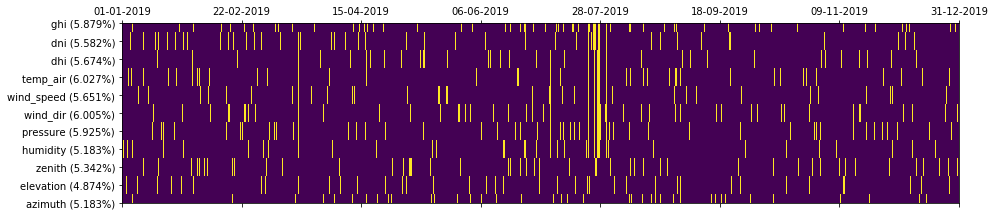

In [ ]:
plot_missing(df_noisy, f = comp([pd.isna, f_std]))

We want a method to visualize anomalies by columns, one by one.
- `view_anomaly` takes a column (a `Series`) and plots the valuer where the outlier function is activated. 

In [ ]:
#export
def view_anomaly(s: Series, f=std_outliers(0,1,3)):
    "Plots the missing/anomaly points"
    _, ax = plt.subplots(figsize=(14,6))
    a = f(s)
    ax.set_title(f' Anomaly rate: ({100*a.values.sum()/len(s):.3f}%)')
    ax.plot(s, color='blue', label = 'Normal')
    ax.scatter(a[a].index, s[a].fillna(0), color='red', label = 'Anomaly')
    ax.legend()
    return ax

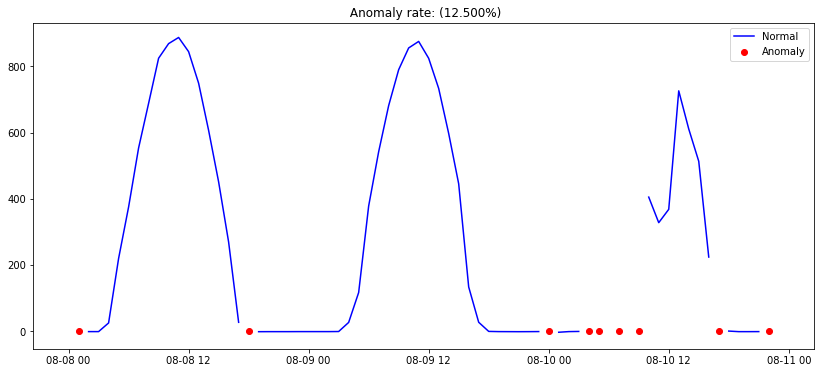

In [ ]:
s = df_noisy.loc['08 Aug 2019':'10 Aug 2019', 'ghi']
f_outlier = comp([pd.isna, std_outliers(s.mean(), s.std())])
view_anomaly(s, f=f_outlier);

The oulier function will mask valid points:

In [ ]:
f_outlier(s['10 Aug 2019'])

Date UTC
2019-08-10 00:00:00     True
2019-08-10 01:00:00    False
2019-08-10 02:00:00    False
2019-08-10 03:00:00    False
2019-08-10 04:00:00     True
2019-08-10 05:00:00     True
2019-08-10 06:00:00    False
2019-08-10 07:00:00     True
2019-08-10 08:00:00    False
2019-08-10 09:00:00     True
2019-08-10 10:00:00    False
2019-08-10 11:00:00    False
2019-08-10 12:00:00    False
2019-08-10 13:00:00    False
2019-08-10 14:00:00    False
2019-08-10 15:00:00    False
2019-08-10 16:00:00    False
2019-08-10 17:00:00     True
2019-08-10 18:00:00    False
2019-08-10 19:00:00    False
2019-08-10 20:00:00    False
2019-08-10 21:00:00    False
2019-08-10 22:00:00     True
2019-08-10 23:00:00    False
Freq: H, Name: ghi, dtype: bool

It is very useful to detect stuck values, 

In [ ]:
s9 = s['9 Aug 2019']

In [ ]:
#exports
def stuck_outlier(tol:float=1e-3, periods=1):
    "Detects if the values are stuck"
    def _inner(df):
        return df.diff().abs().rolling(periods, center=True).max()<tol
    return _inner

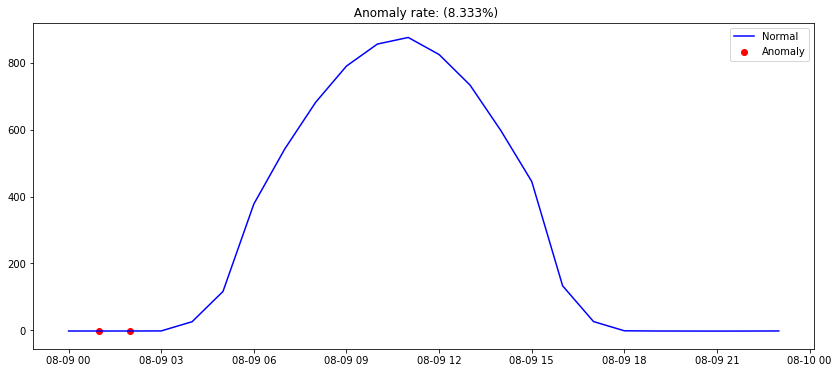

In [ ]:
view_anomaly(s9, stuck_outlier());

## Filter Data

 Don't remember why I needed this

In [ ]:
#export
def percentile_cutoff(data, p_low=5, p_high=95):
    q_low = np.percentile(data,p_low)
    q_high = np.percentile(data, p_high)
    iqr = q_high - q_low
    cut_off = iqr * 1.25
    lower, upper = q_low - cut_off, q_high + cut_off
    return lower, upper

We will build a sklearn compatible `pipeline` to process our data. This will save us time later on

In [ ]:
#export
class MinMaxRemoval(TransformerMixin):
    "Remove values outside Min-Max within a given tolerance"
    def __init__(self, min_max_tol_dict:dict):
        "A dictionary with the [min, max] interval and a tolerance"
        self.d = min_max_tol_dict
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X:DataFrame, y=None):
        "Apply the transform to your data df"
        
        X = X.copy()
        for c, val in self.d.items():
            m, M, tol = val
            X[c] = (X[c].mask(np.abs(X[c] - m) < tol, m)  #min replace
                        .mask(np.abs(X[c] - M) < tol, M)  #max replace
                        .where((m - tol < X[c]) & (X[c] < M + tol))  #else replace by NaN
                   )
        return X

In [ ]:
df.columns

Index(['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed', 'wind_dir', 'pressure',
       'humidity', 'zenith', 'elevation', 'azimuth'],
      dtype='object')

In [ ]:
d = {}
d['temp_air'] = (-20,50,1.0)
d['wind_speed'] = (0,30,0.1)
d['wind_dir'] = (0,360,5.0)
d['ghi'] = (0, 1300,10.0)
d['dni'] = (0, 1300,10.0)
d['dhi'] = (0, 1300,10.0)
d['pressure'] = (900, 1100,1.0)
d['humidity'] = (0,100,1.0)

You need to define the Transoform

In [ ]:
mmr = MinMaxRemoval(d)

In [ ]:
show_doc(MinMaxRemoval.transform)

<h4 id="MinMaxRemoval.transform" class="doc_header"><code>MinMaxRemoval.transform</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>MinMaxRemoval.transform</code>(**`X`**:`DataFrame`, **`y`**=*`None`*)

Apply the transform to your data df

and actually apply to your data

In [ ]:
mm_df = mmr.transform(df)

# Exports -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.core.ipynb.
Converted 01_utils.pandas_hacks.ipynb.
Converted 03_utils.matlab_io.ipynb.
Converted 03_utils.tmy.ipynb.
Converted 04_utils.missing.ipynb.
Converted 05_utils.plot.ipynb.
Converted 06_modelling.mybifacialvf.ipynb.
Converted 07_modelling.mypvfactors.ipynb.
Converted index.ipynb.
